In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from nn_utils import Net, DEVICE, TRAINLOADER, train_nn, test_nn, freeze_parameters

torch.cuda.empty_cache()

PATH = './nn-models/cifar10-nn-model'

# load the pretrained NN model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device=DEVICE)

test_nn(net=net, verbose=True)

Testing on 10,000 test images ...
- Correct: 8335
- Total: 10000
- Accuracy: 83
Parameter containing:
tensor([[[[ 0.1284, -0.1195, -0.0359],
          [ 0.1189, -0.2314,  0.1253],
          [-0.0739,  0.0811,  0.0376]],

         [[ 0.0128,  0.0130,  0.0155],
          [ 0.1048, -0.1248,  0.0124],
          [-0.0555,  0.0005,  0.0168]],

         [[ 0.1883,  0.0210, -0.0783],
          [-0.0683, -0.0649, -0.0646],
          [-0.0700,  0.0045,  0.1285]]],


        [[[ 0.1021, -0.1913,  0.1300],
          [ 0.0533,  0.1995,  0.1313],
          [-0.1663, -0.1806, -0.0947]],

         [[ 0.1551, -0.0442,  0.0827],
          [-0.1020,  0.1933, -0.0868],
          [ 0.1474, -0.0062, -0.1064]],

         [[ 0.0863, -0.1114,  0.0629],
          [-0.0705, -0.0169, -0.1870],
          [-0.0854,  0.1055, -0.0387]]],


        [[[ 0.1794,  0.1327, -0.0315],
          [-0.1408,  0.1181,  0.0502],
          [-0.1375,  0.1298,  0.1176]],

         [[ 0.1591, -0.1258, -0.0485],
          [-0.0188,  0

GA

In [12]:
import array
import random
import json
import numpy as np
from deap import base
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

freeze_parameters(net=net)

# store all the training dataset in a single batch
ALL_IMAGES = []
ALL_LABELS = []
for mini_batch in TRAINLOADER:
    ALL_IMAGES.append(mini_batch[0])
    ALL_LABELS.append(mini_batch[1])

ALL_IMAGES = torch.cat(ALL_IMAGES)
ALL_LABELS = torch.cat(ALL_LABELS)

# count the number of dimensions of the last layer
N_DIMENSION = 0
for param in net.out.parameters():
    N_DIMENSION += param.numel()

LOW_BOUND = -0.1
HIGH_BOUND = 0.3
N_BITS = 8
N_GENERATIONS = 100
MU = 200
CX_PB = 0.9
UNIFORM_CX_PB = 0.5
MUTATE_PB = 0.1
MUTATE_FLIP_PB = 1.0 / (N_DIMENSION * N_BITS)
ELITISM = 5

def decode(individual):
    real_numbers = []
    for i in range(N_DIMENSION):
        chromosome = individual[i*N_BITS:(i+1)*N_BITS]
        bit_string = ''.join(map(str, chromosome))
        num_as_int = int(bit_string, 2) # convert to int from base 2 list
        num_in_range = LOW_BOUND + (HIGH_BOUND - LOW_BOUND) * num_as_int / 2**N_BITS
        real_numbers.append(num_in_range)

    return real_numbers

def calculate_fitness(individual):
    # put the parameters into the neural network
    parameters = decode(individual=individual)
    parameters = torch.as_tensor(parameters, dtype=torch.float32, device=DEVICE)

    net.out.weight = torch.nn.Parameter(data=parameters[0:5120].reshape(10, 512))
    net.out.bias = torch.nn.Parameter(data=parameters[5120:5130])

    # go over the dataset once
    with torch.no_grad():
        # get a mini-batch from the training dataset
        images = ALL_IMAGES[0:1000].to(device=DEVICE)
        labels = ALL_LABELS[0:1000].to(device=DEVICE)

        preds = net(images) # forward mini-batch
        loss = F.cross_entropy(preds, labels) # calculate loss

    return (1 / 0.1 + loss.item()),

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_BITS*N_DIMENSION)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calculate_fitness)
toolbox.register("crossover", tools.cxUniform, indpb=UNIFORM_CX_PB)
toolbox.register("mutate", tools.mutFlipBit, indpb=MUTATE_FLIP_PB)
toolbox.register("select", tools.selTournament, fit_attr='fitness')

def ga():
    # generate initial random population of individuals (parameters)
    pop = toolbox.population(n=MU)

    # evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # track the performance of each generation
    best_individuals = [] 
    worst_individuals = [] 

    # begin the generational process
    for gen in range(1, N_GENERATIONS):

        # select the next generation individuals
        offspring = tools.selBest(pop, ELITISM) + toolbox.select(pop, len(pop)-ELITISM, 2)
        # clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
        # crossover make pairs of all (even, odd) in offspring
        for ind1, ind2 in zip(offspring[4::2], offspring[5::2]):
            if random.random() <= CX_PB:
                toolbox.crossover(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        # mutation
        for mutant in offspring:
            if random.random() <= MUTATE_PB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # population is entirely replaced by the offspring
        pop[:] = offspring

        # track generation
        print(f'==== Generation {gen} finished ====')
        fits = [ind.fitness.values[0] for ind in pop]
        best_individuals.append(min(fits))
        worst_individuals.append(max(fits))

    return pop, best_individuals, worst_individuals
        
pop, best_individuals, worst_individuals = ga()

/user/HS400/sr01303/.local/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


==== Generation 1 finished ====
==== Generation 2 finished ====
==== Generation 3 finished ====
==== Generation 4 finished ====
==== Generation 5 finished ====
==== Generation 6 finished ====
==== Generation 7 finished ====
==== Generation 8 finished ====
==== Generation 9 finished ====
==== Generation 10 finished ====
==== Generation 11 finished ====
==== Generation 12 finished ====
==== Generation 13 finished ====
==== Generation 14 finished ====
==== Generation 15 finished ====
==== Generation 16 finished ====
==== Generation 17 finished ====
==== Generation 18 finished ====
==== Generation 19 finished ====
==== Generation 20 finished ====
==== Generation 21 finished ====
==== Generation 22 finished ====
==== Generation 23 finished ====
==== Generation 24 finished ====
==== Generation 25 finished ====
==== Generation 26 finished ====
==== Generation 27 finished ====
==== Generation 28 finished ====
==== Generation 29 finished ====
==== Generation 30 finished ====
==== Generation 31 

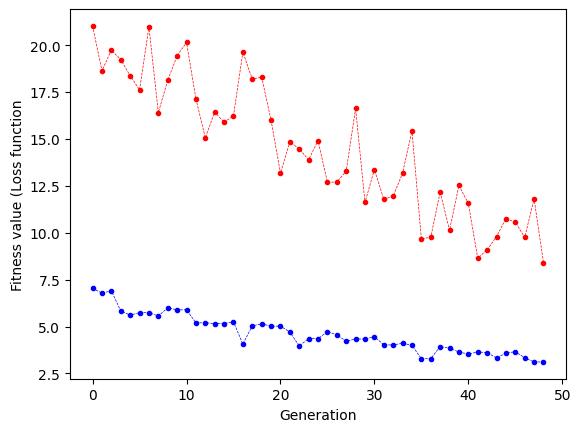

In [5]:
best_individual = tools.selBest(pop, 1)[0]

plt.plot(np.array(best_individuals), color='b', linestyle='dashed', marker='.', linewidth=0.5, label='Worst individual')
plt.plot(np.array(worst_individuals), color='r', linestyle='dashed', marker='.', linewidth=0.5, label='Best individual')
plt.ylabel('Fitness value (Loss function')
plt.xlabel('Generation')
plt.show()

In [8]:
# put best parameters back into the neural network
parameters = torch.as_tensor(best_individual, dtype=torch.float32, device=DEVICE)
net.out.weight = torch.nn.Parameter(data=parameters[0:5120].reshape(10, 512))
net.out.bias = torch.nn.Parameter(data=parameters[5120:5130])

print(net.out.weight.shape)
print(net.out.bias.shape)

# test the neural network
test_nn(net=net, verbose=True)

torch.Size([10, 512])
torch.Size([10])
Testing on 10,000 test images ...
- Correct: 750
- Total: 10000
- Accuracy: 7


7